# <a id='toc1_'></a>[Epidemics simulations](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Epidemics simulations](#toc1_)    
  - [Gillespie Allgorithm!!](#toc1_1_)    
  - [Epidemic class](#toc1_2_)    
  - [SI model](#toc1_3_)    
    - [SI class](#toc1_3_1_)    
    - [Tests](#toc1_3_2_)    
    - [SI wihout transmition](#toc1_3_3_)    
      - [Tests](#toc1_3_3_1_)    
  - [SIR model](#toc1_4_)    
    - [SIR class](#toc1_4_1_)    
    - [Tests](#toc1_4_2_)    
  - [SIRS and endemic transition](#toc1_5_)    
    - [SIRS class](#toc1_5_1_)    
    - [Tests](#toc1_5_2_)    
  - [Extra](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt     
from random import randrange                                                                                  
from tkinter import*
from tkinter import ttk,font                         
import os  
from PIL import Image,ImageTk

general_directory=os.getcwd()+'\\'

%matplotlib inline

## <a id='toc1_1_'></a>[Gillespie Allgorithm!!](#toc0_)

In [44]:
''' 
X0 starting state
T list of jumping times
tend stop when reaching this time
M stoichiometric matrix
k list of reaction constants
prop_f function that computes the porpensities of each reaction
'''

def ssa_step(X0,T,tend,M,k,prop_f,batch_size=1000):
    

    x0 = X0[-1]  # take last value
    t  = T[-1]   # take last time
    K  = M.shape[0] # number of reactionsx

    newX = np.zeros( [batch_size,len(x0)] ) # we create a new matrix of values, that will be filled one at a time
                                            # If it is not big enough, we will enlarge it
    newT = np.zeros( batch_size ) 
    
    index = 0 # this is the index to the current position in the matrix.
    while t<tend:

        a = prop_f(x0,k)  # compute the propensity values "a", using prop_f 

        # compute the total propensity a_tot
        a_T=sum(a)

        #normalize the propensity 
        P = a/a_T
        
        r1 = np.random.random() # generate the first random number using np.random.random() to compute jumping time
        # compute tau, the time for the next jump
        tau=(1/a_T)*np.log(1/r1) 
        newT[index] = t = t + tau # this updates t to be t+tau, and also save it in the list newT

        # generate the second random number to select reaction
        r2 = np.random.random()
        
        acum = 0.0
        reaction = 0

        # select the reaction according to r2
        
        for i in range(K): # number of reactions
            # accumulate in acum
            acum=sum(P[:i+1])
            # update reaction
            if acum>r2:
                reaction=i
                break;    
            
        newX[index] = x0 = x0 + M[reaction]
        index += 1 # this increments the index
        
        #
        #  Dont touch this. This extends the array newT and newX if needed
        #
        if index%batch_size == 0: # if you filled the whole batch, add more space
            newX = np.append(newX,np.zeros( [batch_size,len(x0)] ),axis=0)
            newT = np.append(newT,np.zeros( batch_size ))   
    return np.append(X0,newX[0:index,:],axis=0), np.append(T,newT[0:index])  

## <a id='toc1_2_'></a>[Epidemic class](#toc0_)

In [52]:
class epidemic():
    def __init__(self):
        self.only_infected_red=True
        self.X0 = np.zeros([1,3])
        self.T = np.zeros(1)
        
    def Simulation(self):
    

        self.X0, self.T = ssa_step(self.X0,self.T,self.time,self.M,self.k,self.propensity_f)
 
      
    def Plot(self):
        plt.Figure()
        for j in range(len(self.X0[0])):
            color_susceptible='#FFC107'
            color_infected='#E52527'
            color_recovery='#43cc29'
            if j==1: 
                color_p = color_infected
                label_text='Infected'
            elif j==2: 
                color_p = color_recovery
                label_text='Recovered'
            elif j==0: 
                color_p=color_susceptible
                label_text='Susceptible'
            plt.plot(self.T,self.X0[:,j]/self.N,label=label_text,color=color_p)
         
        plt.xlabel('T')
        plt.ylabel('X')
        plt.legend()
        plt.title('Path of pandemic')
        plt.savefig('SIR_plot.png')        
        plt.show()

    def Multtiple_simulations(self,n):
        for i in range(n):
            self.Simulation()
            plt.plot(self.T,self.X0[:,0],label="Susceptibles",color='#FFC107')
            plt.plot(self.T,self.X0[:,1],label="Infected",color='#E52527')
            plt.plot(self.T,self.X0[:,2],label="Recovered",color='#43cc29')
            self.X0[-1] = [self.N-self.I , self.I, 0]
            self.T[-1] = 0

        plt.xlabel('T')
        plt.ylabel('X')
        plt.title('Path of '+ str(n)+' initialy equal pandemics')

  
    def update_simulation(self):
        if all([self.x0<len(self.X0)-1,not self.pause]):
            

            #clear GUI
            for space in self.compartiments: space.delete('all')
          

            color_susceptible='#FFC107'
            color_infected='#E52527'
            color_recovery='#43cc29'


            for i in range(len(self.compartiments)):

                for j in range(len(self.X0[self.x0])):
                    if j==1: color = color_infected
                    elif j==2: color = color_recovery
                    else: color=color_susceptible
                    for k in range(int(self.X0[self.x0][j])):
                        self.compartiments[i].create_text(randrange(10,self.dimensions-10),randrange(10,self.dimensions-10),text="",font=('Roboto 13 bold'),fill=color)
 
            self.x0=self.x0+1
    
            self.frame.after(1,self.update_simulation)
    
    
    def visual_simulation(self):
        self.pause=False
        self.update_simulation()

    def Reset(self):
        self.Pause()
        for space in self.compartiments: space.delete('all')
        self.x0=0

    def Pause(self):
        self.pause=True

    def Foward(self):
        self.x0+=100

    def Back(self):
        if self.x0>100:self.x0+=-100


    def App(self):
        self.x0=0
        self.Simulation()
        self.Plot()

        ####################
        self.root=Tk()
        self.root.title('City SIR analysis')

        self.Text= Frame(self.root,bg='#F0F5FA')
        self.Text.pack(side='top',fill='both',expand='yes')
        self.root_text=ttk.Label(self.Text,text='City SIR analysis',font=('Roboto 25 bold'),foreground='#5B62F4',background='#F0F5FA')
        self.root_text.pack(pady=20)

        self.frame=Frame(self.root)
        self.frame.pack()
        

        self.dimensions=530

        #Responsive design

        self.City=Frame(self.frame)
        self.City.pack(side='right',pady=10,padx=40)

        self.Plot_F=Frame(self.frame)
        
        self.Plot_F.pack(side='left',pady=10,padx=40)
    
        win_width=self.dimensions
        win_height=self.dimensions+140
        screen_widht=self.root.winfo_screenwidth()
        screen_height=self.root.winfo_screenheight()
        x=(screen_widht/2)-(win_width/2)
        y=(screen_height/2)-(win_height/2)
        self.root.geometry("%dx%d+%d+%d"%(win_width,win_height,x,y))


        self.city=Canvas(self.City,width=self.dimensions,height=self.dimensions,background='white')
        self.city.pack()

    
        #self.plot=Canvas(self.Plot_F,width=550,height=550)
        bg=Image.open('SIR_plot.png')
        bg=bg.resize((self.dimensions,self.dimensions))
        self.bg=ImageTk.PhotoImage(image=bg)
        self.plot=Label(self.Plot_F,image=self.bg,width=self.dimensions,height=self.dimensions,foreground='white')
        #self.plot.self.bg=self.bg
        self.plot.pack()
        #self.plot.create_image(0,0,anchor='nw',image= self.bg)
 

        self.compartiments=[self.city]

        #Style
        self.root.configure(background='#D9E3F1')
        self.frame.configure(background='#D9E3F1')
        self.City.configure(background='#D9E3F1')
        #self.Plot_F.configure(background='#D9E3F1')
   

        #Button

        self.Back_butt=Button(self.root, text="",command=lambda : self.Back(),foreground='white',background='#378DFC',font=font.Font(family="Roboto",size=17),relief='sunken')
        self.Back_butt.pack(side='left',expand=YES,fill=BOTH)    

        self.Play_butt=Button(self.root, text="",command=lambda : self.visual_simulation(),foreground='white',background='#378DFC',font=font.Font(family="Roboto",size=17),relief='sunken')
        self.Play_butt.pack(side='left',expand=YES,fill=BOTH)

        
        self.Pause_butt=Button(self.root, text="",command=lambda : self.Pause(),foreground='white',background='#378DFC',font=font.Font(family="Roboto",size=17),relief='sunken')
        self.Pause_butt.pack(side='left',expand=YES,fill=BOTH)

        self.Foward_butt=Button(self.root, text="",command=lambda : self.Foward(),foreground='white',background='#378DFC',font=font.Font(family="Roboto",size=17),relief='sunken')
        self.Foward_butt.pack(side='right',expand=YES,fill=BOTH)   

        self.Clear_butt=Button(self.root, text="",command=lambda : self.Reset(),foreground='white',background='#378DFC',font=font.Font(family="Roboto",size=17),relief='sunken')
        self.Clear_butt.pack(side='right',expand=YES,fill=BOTH)
       


        self.root.mainloop()        
  

## <a id='toc1_3_'></a>[SI model](#toc0_)

### <a id='toc1_3_1_'></a>[SI class](#toc0_)

In [48]:
class SI (epidemic):
        def __init__ (self,N=1000,I=10,β=0.02,time=100): 
                self.X0 = np.zeros([1,2])
                self.T = np.zeros(1)
                self.N=N
                self.I=I
                self.β=β #infection rate

                self.time=time
                self.X0 [0] = [self.N-self.I , self.I]
                self.M = np.array([ [-1,1]])  # Infection reaction 
                self.k = np.array([self.β] )  # contact rate 

        def propensity_f(self,x,k):
        # SIR setting
        # S + I -[β]-> 2 I
                tot = sum(x)
                return np.array([k[0]*x[0]*x[1]/tot])



### <a id='toc1_3_2_'></a>[Tests](#toc0_)

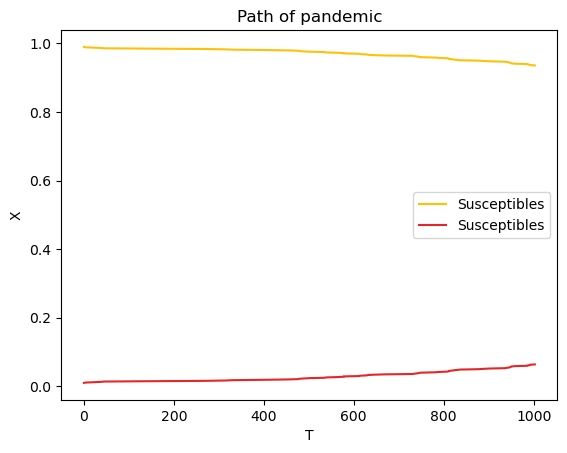

In [21]:
si=SI(N=1000,I=10,β=0.002,time=1000)
si.Simulation()
si.Plot()


### <a id='toc1_3_3_'></a>[SI wihout transmition](#toc0_)

In [49]:
class SI_not_transmition (SI):
        def __init__ (self,N=1000,I=10,β=0.2,time=100):
                super().__init__(N,I,β,time)

        def propensity_f(self,x,k):
    # SIR setting
    # S -[β]-> I
            tot = sum(x)
            return np.array([k[0]*x[0]])

#### <a id='toc1_3_3_1_'></a>[Tests](#toc0_)

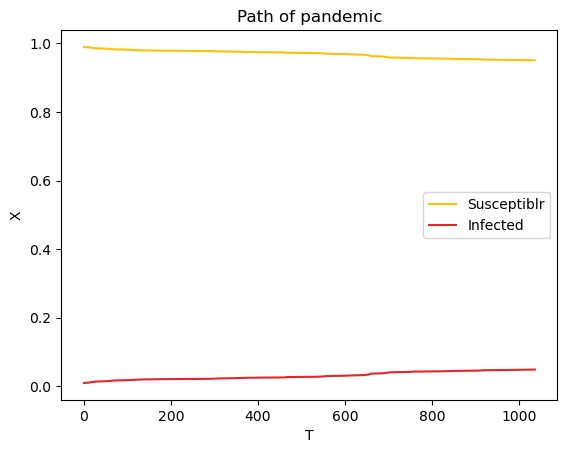

In [50]:
SI_notI=SI_not_transmition(N=1000,I=10,β=5/100000,time=1000)
SI_notI.Simulation()
SI_notI.Plot()

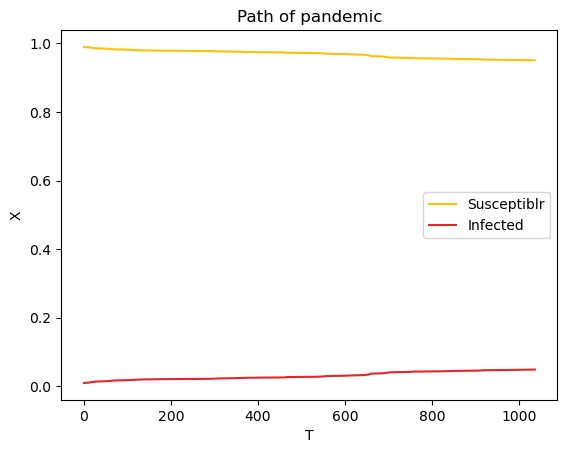

In [51]:
SI_notI.App()

## <a id='toc1_4_'></a>[SIR model](#toc0_)

### <a id='toc1_4_1_'></a>[SIR class](#toc0_)

In [ ]:
class SIR(epidemic):
    def __init__ (self,N=1000,I=10,β=0.02,μ=0.01,time=100): 
        self.X0 = np.zeros([1,3])
        self.T = np.zeros(1)
        self.N=N
        self.I=I
        self.β=β #infection rate
        self.μ=μ #recovery rate
        self.time=time
        self.X0 [0] = [self.N-self.I , self.I, 0]
        self.M = np.array([ [-1,1,0],  # Infection reaction
                            [0,-1,1]]) # Recovery reaction
        self.k = np.array([self.β, self.μ] )  # contact rate and recovery rate
                                                        
    def propensity_f(self,x,k):
    # SIR setting
    # S + I -[β]-> 2 I
    

    # this function you have to fill with the reactions speeds.
    
    #print(x,"\n",k,"\n")
        tot = sum(x)
        return np.array([k[0]*x[0]*x[1]/tot, 
                     k[1]*x[1]])


### <a id='toc1_4_2_'></a>[Tests](#toc0_)

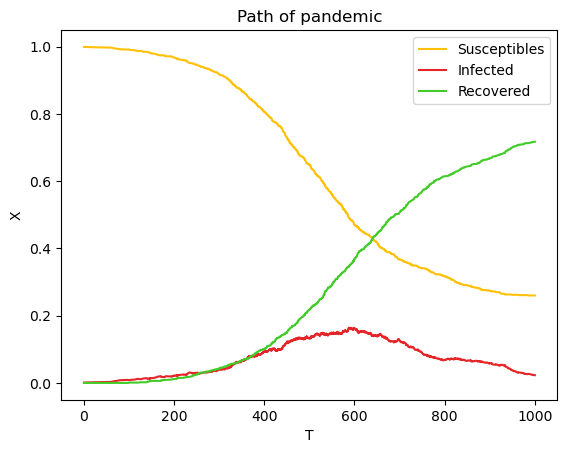

In [55]:
Game=SIR(N=1000,I=1,β=0.02,μ=0.01,time=1000)
Game.Simulation()
Game.Plot()


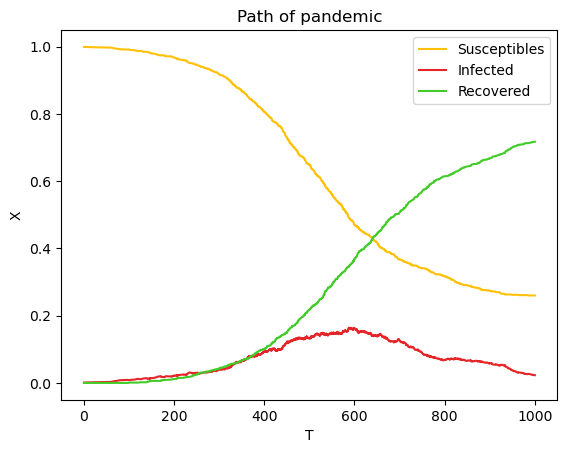

In [56]:
Game.App()


## <a id='toc1_5_'></a>[SIRS and endemic transition](#toc0_)

### <a id='toc1_5_1_'></a>[SIRS class](#toc0_)

In [53]:
class SIRS(epidemic):
    def __init__ (self,N=1000,I=333,β=0.02,μ=0.01,η=0.01,time=1000): 
        self.X0 = np.zeros([1,3])
        self.T = np.zeros(1)
        self.N=N
        self.I=I
        self.β=β #infection rate
        self.μ=μ #recovery rate
        self.η=η #vulnerabilitation rate
        self.time=time
        self.X0 [0] = [self.N-self.I , self.I, 0]
        self.M =np.array([[-1, 1, 0] ,# Infectious reaction
                            [0,-1,1] , # I->R Recovery reaction
                            [1,0,-1] ]) # R->S
        self.k = np.array([self.β, self.μ,self.η] )  # contact, recovery and vulnerabilitation rate
                                                        
    def propensity_f(self,x,k):

    # SIRS setting
    # S + I -[β]-> 2 I
    #     I -[μ]-> R
    #     R -[η]-> S

        tot = sum(x)
        return np.array([k[0]*x[0]*x[1]/tot, 
                     k[1]*x[1], k[2]*x[2] ]  )


### <a id='toc1_5_2_'></a>[Tests](#toc0_)

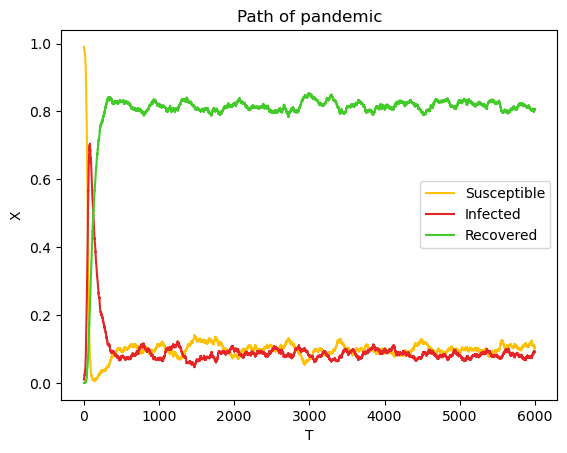

In [59]:
sirs=SIRS(N=1000,I=10,β=0.1,μ=0.01,η=0.001,time=6000)
sirs.Simulation()
sirs.Plot()

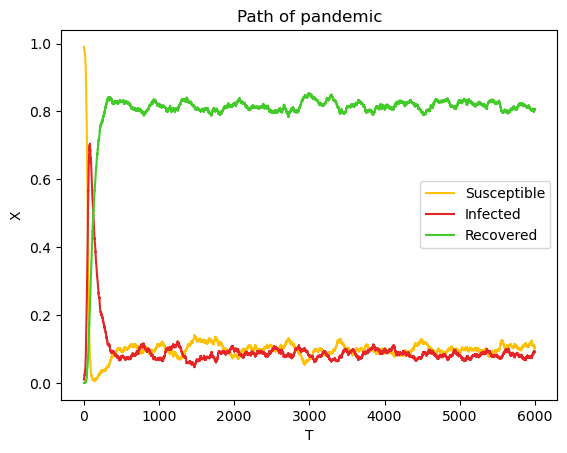

In [60]:
sirs.App()

## <a id='toc1_6_'></a>[Extra](#toc0_)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

#plt.style.use('seaborn-poster')
%matplotlib inline


In [ ]:
β=0.02
μ=0.01
η=0.01
F = lambda t, s: [-β*s[0]*s[1]+η*s[2],
                  β*s[0]*s[1]-μ * s[1], 
                  μ * s[1]-η*s[2]]
tmax = 1000
t_eval = np.arange(0, tmax+0.01, 0.01)
sol = solve_ivp(F, [0, tmax],[0.333, 0.333,0.334], t_eval=t_eval)

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(T,X0[:,0]/1000.0,"-")
plt.plot(T,X0[:,1]/1000.0,"-")
plt.plot(T,X0[:,2]/1000.0,"-")
plt.plot(t_eval,sol.y.T[:, 0])
plt.plot(t_eval,sol.y.T[:, 1])
plt.plot(t_eval,sol.y.T[:, 2])
#, sol.y.T[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
β=0.01
μ=0.01
η=0.01
F = lambda t, s: [-β*s[0]*s[1]+η*s[2],
                  β*s[0]*s[1]-μ * s[1], 
                  μ * s[1]-η*s[2]]
tmax = 1000
t_eval = np.arange(0, tmax+0.01, 0.01)
sol = solve_ivp(F, [0, tmax],[0.333, 0.333,0.334], t_eval=t_eval)

plt.figure(figsize = (12, 8))
plt.plot(t_eval,sol.y.T[:, 0])
plt.plot(t_eval,sol.y.T[:, 1])
plt.plot(t_eval,sol.y.T[:, 2])
#, sol.y.T[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()